# TextCL Tutorial

1. [Introduction](#Introduction)
2. [Preparation](#Preparation)
3. [Filtering on language](#Filtering-on-language)
4. [Filtering on Jaccard similarity](#Filtering-on-Jaccard-similarity)
5. [Filtering on perplexity score](#Filtering-on-perplexity-score)
6. [Outliers filtering](#Outliers-filtering)
7. [Plots for outlier detection](#Plots-for-outlier-detection)

## Introduction

This tutorial demonstrates how to preprocess text to clean it up for the modeling stage. Modeling can include classification models, NER (Named Entity Recognition) models, spell checking models, text summarization and generation, as well as prediction models. Usually, this analysis is performed manually and is very time-consuming. The TextCL package helps to identify and filter out (1) sentences in languages other than the target language, (2) linguistically unconnected and/or corrupted sentences, and (3) duplicate sentences.

Another feature of the package is to identify and filter out outliers from the text scope. As outliers, we consider texts that don't contextually belong to the main topic of the text. It's important to be able to identify these anomalies without having labeled data, so we can have a general algorithm for unstructured texts and find out the scope blocks.

In this tutorial, we will work with the [BBC data set](http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip) and additional manually generated sentences to demonstrate the package's functionality. Overall, the package can be used with any text data set loaded as a [Pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

The package contains the following functions for text cleaning:

1. Filtering on language
2. Filtering on Jaccard similarity
3. Filtering on perplexity score
4. Outliers filtering

The first three functions work at the sentence level for each text in the scope. In turn, the outlier filtering function works at the level of the full text. The latter implements 3 different outlier detection algorithms: [TONMF](https://arxiv.org/pdf/1701.01325.pdf), [RPCA](https://github.com/dganguli/robust-pca), and [SVD](https://api.semanticscholar.org/CorpusID:123532178), with `l2` normalisation by default (can be changed to the `l1`, `l2`, or `max` via the `norm` parameter).

## Preparation

Load package and dependencies:

In [57]:
import textcl
import pandas as pd
import numpy as np
import random

#set up seed for reproducibility
seed = 1
np.random.seed(seed)
random.seed(seed)

Let's prepare the input data from the [modified BBC dataset](https://github.com/alinapetukhova/textcl/blob/master/examples/prepared_bbc_dataset.csv) bundled with TextCL. First, load the text data. The sample file is located in the `examples` folder, next to this tutorial.

In [58]:
SOURCE_FILE_PATH = 'prepared_bbc_dataset.csv'

input_texts_df = pd.read_csv(SOURCE_FILE_PATH).reset_index()
print("Num texts in the data set: {}".format(len(input_texts_df)))

Num texts in the data set: 21


In this example we'll use a subset of the BBC News data set containing 5 topics (business, entertainment, politics, sport, tech) with manually inserted texts to demonstrate the capabilities of the package. Here's how the dataset looks like:

In [59]:
input_texts_df

,index,topic_name,text
0,0,business,WorldCom bosses' $54m payout Ten former direc...
1,1,business,Profits slide at India's Dr Reddy Profits at ...
2,2,business,Liberian economy starts to grow The Liberian ...
3,3,business,"Uluslararası Para Fonu (IMF), Liberya ekonomis..."
4,4,entertainment,Singer Ian Brown 'in gig arrest' Former Stone...
5,5,entertainment,Blue beat U2 to top France honour Irish band ...
6,6,entertainment,Housewives lift Channel 4 ratings The debut o...
7,7,entertainment,Домохозяйки подняли рейтинги канала 4 Дебют ам...
8,8,entertainment,Housewives Channel 4 reytinglerini yükseltti A...
9,9,politics,Observers to monitor UK election Ministers wi...


## Split texts into sentences

To be able to process/filter sentences from the data set separately, we first need to split our texts into sentences as rows in a Pandas data frame. The [`split_into_sentences()`](https://alinapetukhova.github.io/textcl/docs/preprocessing.html#textcl.preprocessing.split_into_sentences) function is used for this purpose.

Notice the data loaded in the previous section has a column named `text`. By default, the `split_into_sentences()` function expects to find texts in this column. However, an alternative name for this column can be specified in the function's `text_col` parameter.

Splitting the data set texts into sentences is done as follows, using the `split_into_sentences()` function:

In [60]:
split_input_texts_df = textcl.split_into_sentences(input_texts_df)
print("Num sentences before filtering: {}".format(len(split_input_texts_df)))

Num sentences before filtering: 319


After splitting text data set into sentences, the number of rows increased from 21 to 319. Let's review them:

In [61]:
split_input_texts_df.head()

,index,topic_name,text,sentence
0,0,business,WorldCom bosses' $54m payout Ten former direc...,WorldCom bosses' $54m payout Ten former direc...
1,0,business,WorldCom bosses' $54m payout Ten former direc...,"James Wareham, a lawyer representing one of t..."
2,0,business,WorldCom bosses' $54m payout Ten former direc...,The remaining $36m will be paid by the directo...
3,0,business,WorldCom bosses' $54m payout Ten former direc...,"But, a spokesman for the prosecutor, New York ..."
4,0,business,WorldCom bosses' $54m payout Ten former direc...,Corporate governance experts said that if the...


As shown in this example, the `split_into_sentences()` function places sentences in the `sentence` column by default. This can be changed using the function's `sentence_col` parameter.

## Filtering on language

Let's check how the language filtering function works with manually inserted texts in Russian and Turkish languages to the initial set.

To do this we'll use the [`language_filtering()`](https://alinapetukhova.github.io/textcl/docs/preprocessing.html#textcl.preprocessing.language_filtering) function, which filters sentences by language. The input to this function should be a Pandas data frame (with `sentence` column), a threshold value, and a target language. Language score is the threshold used for filtering, with the default value of 0.99. The function makes use of the `detect_language` function from the [langdetect](https://pypi.org/project/langdetect/) package, which returns probabilities of a text belonging to a certain language. All sentences below this threshold will be filtered out.

In [62]:
split_input_texts_df = textcl.language_filtering(split_input_texts_df, threshold=0.99, language='en')
print("Num sentences after language filtering: {}".format(len(split_input_texts_df)))

Num sentences after language filtering: 281


The number of rows with sentences was reduced from 319 to 281. Join sentences to the initial texts to review the results:

In [63]:
textcl.join_sentences_by_label(split_input_texts_df, label_col = 'index')

,index,sentence
0,0,WorldCom bosses' $54m payout Ten former direc...
1,1,Profits slide at India's Dr Reddy Profits at ...
2,2,Liberian economy starts to grow The Liberian ...
3,4,Singer Ian Brown 'in gig arrest' Former Stone...
4,5,Blue beat U2 to top France honour Irish band ...
5,6,Housewives lift Channel 4 ratings The debut o...
6,9,Observers to monitor UK election Ministers wi...
7,10,Lib Dems highlight problem debt People vulner...
8,11,Minister defends hunting ban law The law bann...
9,12,Legendary Dutch boss Michels dies Legendary D...


As we can see, texts with index 3 (Turkish), 7 (Russian) and 8 (Turkish) were removed.

## Filtering on Jaccard similarity

Function [`jaccard_sim_filtering()`](https://alinapetukhova.github.io/textcl/docs/preprocessing.html#textcl.preprocessing.jaccard_sim_filtering) is used to filter sentences by [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index). It represents each sentence as an array of tokens and finds the intersection between each pair of arrays / sentences. Using the intersection, the similarity score is calculated; if it's above the specified `threshold`, a sentence will be filtered out.

In [64]:
split_input_texts_df = textcl.jaccard_sim_filtering(split_input_texts_df, threshold=0.8)
print("Num sentences after Jaccard sim filtering: {}".format(len(split_input_texts_df)))

Num sentences after Jaccard sim filtering: 258


The number of rows with sentences was reduced from 281 to 258. Join sentences to the initial texts to review the results:

In [65]:
textcl.join_sentences_by_label(split_input_texts_df, label_col = 'index')

,index,sentence
0,0,WorldCom bosses' $54m payout Ten former direc...
1,1,Profits slide at India's Dr Reddy Profits at ...
2,2,Liberian economy starts to grow The Liberian ...
3,4,Singer Ian Brown 'in gig arrest' Former Stone...
4,5,Blue beat U2 to top France honour Irish band ...
5,6,Housewives lift Channel 4 ratings The debut o...
6,9,Observers to monitor UK election Ministers wi...
7,10,Lib Dems highlight problem debt People vulner...
8,11,Minister defends hunting ban law The law bann...
9,12,Legendary Dutch boss Michels dies Legendary D...


Text with $id=17$ was removed as it was a partial duplicate of text with $id=18$.

## Filtering on perplexity score

Function [`perplexity_filtering()`](https://alinapetukhova.github.io/textcl/docs/preprocessing.html#textcl.preprocessing.perplexity_filtering) is used to filter sentences by perplexity, i.e., when sentences are linguistically incorrect and/or unconnected with the remaining text. 

In general, **perplexity** is a measurement of how well a probability distribution or probability model predicts a sample. In the case of the text data, we will be checking the probability of the next word to be in the given sentence. A low perplexity indicates the probability distribution is good at predicting the word.

The first step creates contextual tokens to capture latent syntactic-semantic information provided by the [pytorch_pretrained_bert](https://pypi.org/project/pytorch-pretrained-bert/) package with pretrained `openai-gpt` tokenizer and using GPT as a language model with `OpenAIGPTLMHeadModel`. Perplexity is calculated as `exp(loss)` (where **loss** is the language modeling loss of a particular token).

In [66]:
split_input_texts_df = textcl.perplexity_filtering(split_input_texts_df, threshold=1000)
print("Num sentences after perplexity filtering: {}".format(len(split_input_texts_df)))

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Num sentences after perplexity filtering: 246


The number of rows with sentences was reduced from 258 to the 246. Join sentences to the initial texts to review the results:

In [67]:
textcl.join_sentences_by_label(split_input_texts_df, label_col = 'index')

,index,sentence
0,0,WorldCom bosses' $54m payout Ten former direc...
1,1,Profits slide at India's Dr Reddy Profits at ...
2,2,Liberian economy starts to grow The Liberian ...
3,4,Singer Ian Brown 'in gig arrest' Former Stone...
4,5,Blue beat U2 to top France honour Irish band ...
5,6,Housewives lift Channel 4 ratings The debut o...
6,9,Observers to monitor UK election Ministers wi...
7,10,Lib Dems highlight problem debt People vulner...
8,11,Minister defends hunting ban law The law bann...
9,12,Legendary Dutch boss Michels dies Legendary D...


Text with $id=19$ was removed because sentence *"data clear additional 78.0 long-term 43 those)"* is not linguistically correct.

## Outliers filtering

Text data is uniquely challenging to outlier detection because of its sparsity and high-dimensional nature. In this package we will use Non-Negative Matrix Factorization (NMF) to detect the text topics in an unsupervised fashion, so the model can be trained and be able to detect outliers without labeling of topics. 

The way it works is that NMF decomposes high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative, which also means their coefficients are non-negative. With this approach, we can see the fact that NMF is similar to probabilistic latent semantic indexing (pLSI) and latent Dirichlet allocation (LDA) generative models. From the original matrix, $A$, NMF yields two matrices, $W$ and $H$. The former represents the topics detected in the text data set, while the latter contains the weights for those topics. In other words, $A$ is the documents by words matrix, $H$ is the articles by topics matrix and $W$ is the topics by words matrix.

The [`outlier_detection()`](https://alinapetukhova.github.io/textcl/docs/outliers_detection.html#textcl.outliers_detection.outlier_detection) function is used to detect outliers in a list of sentences based on the contextual information using unsupervised methods. Text embeddings are created as a bag of words as an input for the implemented algorithms. The main input parameters for this function are the Pandas data frame containing the texts, the method to use for outlier detection ([TONMF](https://arxiv.org/pdf/1701.01325.pdf) by default), and the type of norm (`l2` by default) to normalize the obtained matrix and detecting the unrelated texts.

To test this, we'll first join sentences to the text after filtering and selecting the "tech" category. This category has a manually inserted outlier ($id=20$) with a person profile instead of text on the subject of "tech".

In [68]:
joined_texts = split_input_texts_df[["index", "text", "topic_name"]].drop_duplicates()
joined_texts = joined_texts[joined_texts.topic_name == 'tech']
joined_texts

,index,text,topic_name
168,15,Mobile games come of age The BBC News website...,tech
212,16,PlayStation 3 processor unveiled The Cell pro...,tech
233,18,PC photo printers challenge pros Home printed...,tech
253,20,Janice Dean currently serves as senior meteoro...,tech


Let's run the `outlier_detection()` function with the [RPCA](https://github.com/dganguli/robust-pca) algorithm:

In [69]:
joined_texts, _ = textcl.outlier_detection(joined_texts, method='rpca', Z_threshold=1.0)

[nltk_data] Downloading package stopwords to ~/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The contents of `joined_texts` are now as follows:

In [70]:
joined_texts

,index,text,topic_name,words,Z_score
168,15,Mobile games come of age The BBC News website...,tech,Mobile games come age BBC News website takes l...,0.954468
212,16,PlayStation 3 processor unveiled The Cell pro...,tech,PlayStation 3 processor unveiled Cell processo...,0.431154
233,18,PC photo printers challenge pros Home printed...,tech,PC photo printers challenge pros Home printed ...,0.292867


Text with $id=20$ was removed because it describes a person profile instead of tech news.


## Plots for outlier detection

In this section we'll visualize the outliers for the BBC data set obtained with the different algorithms. First load additional libraries required for results visualization:

In [71]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics

We'll use the [NLTK](https://www.nltk.org/) library to filter stop words from the initial dataset. Let's import this library and download the stop words list:

In [72]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to ~/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Prepare input data from the BBC dataset

To demonstrate how the package handles outlier detection tasks, we present a simplified example from a real world data set to show how skewed the typical values of the corresponding column $z(x)$ may be in real scenarios. To build plots for the outlier detection functions we'll need to load the [full BBC dataset](http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip) and apply initial basic text cleaning:

In [73]:
# Download from http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip and unpack to this folder:
dataset_path = "./datasets/bbc"

bbc_dataset = pd.DataFrame([], columns = ['class_name', 'text'])

# Create a list of topics from the folder names based on the data set initial structure
list_topic_folders = os.listdir("{}/".format(dataset_path))

# Get documents per each topic from the corresponding folder
for topic_folder in list_topic_folders:
    
    # Skip ReadMe.txt file
    if "txt" not in topic_folder.lower():
        list_of_files = os.listdir("{}/{}".format(dataset_path, topic_folder))
        
        # add to the Pandas data frame each text document in the folder
        for file in list_of_files:
            if file.find(".txt") != -1 and file.find("ipynb") == -1:
                with open("{}/{}/{}".format(dataset_path, topic_folder, file), 'rb') as f:
                    text = f.read()
                text = text.decode('windows-1252').replace('\n', ' ')
                bbc_dataset = bbc_dataset.append(pd.DataFrame([[topic_folder, text]], columns = ['class_name', 'text']))

# reset index in the final data frame to get identifier column for each document
bbc_dataset = bbc_dataset.reset_index(drop=True)
bbc_dataset.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Columns: 2 entries, class_name to text
dtypes: object(2)
memory usage: 34.9+ KB


Data set contains 2225 texts from the following categories:

In [74]:
for cat in bbc_dataset['class_name'].unique():
    print(cat)

business
sport
entertainment
politics
tech


Get data for "business" and "politics" classes to form the core of the data set:

In [75]:
bus_and_pol = bbc_dataset[(bbc_dataset['class_name'] == "business") | (bbc_dataset['class_name'] == "politics")]
df_bus_and_pol_texts = pd.DataFrame(list(bus_and_pol.text.values), columns=['text'])
df_bus_and_pol_texts['y_true'] = 0

Get 50 random outliers documents from "tech" class:

In [76]:
text_for_outliers = bbc_dataset[bbc_dataset['class_name'] == "tech"]

text_for_outliers = text_for_outliers.iloc[random.sample(range(0, len(text_for_outliers)), 50)]
df_outliers = pd.DataFrame(list(text_for_outliers.text.values), columns=['text'])
df_outliers['y_true'] = 1

Add outliers documents to the core data set and shuffle:

In [77]:
df_test = pd.concat([df_bus_and_pol_texts, df_outliers])
df_test = df_test.sample(frac=1, random_state=seed).reset_index(drop=True)

stop = stopwords.words('english')

df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test

,text,y_true
0,'Ultimate game' award Doom 3 Sci-fi shooter Do...,1
1,Schools take part mock poll Record numbers sch...,0
2,Leaders meet Turkish EU bid Tony Blair met Ita...,0
3,Ukraine trims privatisation check Ukraine revi...,0
4,Bush get 'tough' deficit US president George W...,0
...,...,...
972,Tory leader urges Harry apology Prince Harry p...,0
973,"Barclays profits hit record level Barclays, UK...",0
974,Lib Dems stress Budget trust gap Public trust ...,0
975,Alfa Romeos 'to get GM engines' Fiat stop maki...,0


Convert texts to a bag of words using sklearn's [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class:

In [78]:
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df_test['text']).todense()

Note that `CountVectorizer` is used as an example. We could have used another tokenizer or word embedding.

In the following subsections we'll plot the outlier detection results using the three methods included with TextCL, namely [TONMF](https://arxiv.org/pdf/1701.01325.pdf), [RPCA](https://github.com/dganguli/robust-pca), and [SVD](https://api.semanticscholar.org/CorpusID:123532178).

### TONMF

The [`tonmf()`](https://alinapetukhova.github.io/textcl/docs/outliers_detection.html#textcl.outliers_detection.tonmf) function uses the TONMF algorithm to obtain the outlier matrix. The solution is based on the non-negative matrix factorization with the extension of the block coordinate descent framework.

In [79]:
outlier_matrix,_,_,_ = textcl.tonmf(bag_of_words, k=10, alpha=10, beta=0.05)

Normalize with l2-normalization:

In [80]:
_, y_pred = preprocessing.normalize(outlier_matrix, axis = 1, norm = 'l2', return_norm = True)

Use ROC curve to plot the results of the algorithm:

Text(0.5, 1.0, 'BBC dataset TONMF ROC-curve. K=3, alpha = 1, beta = 0.5')

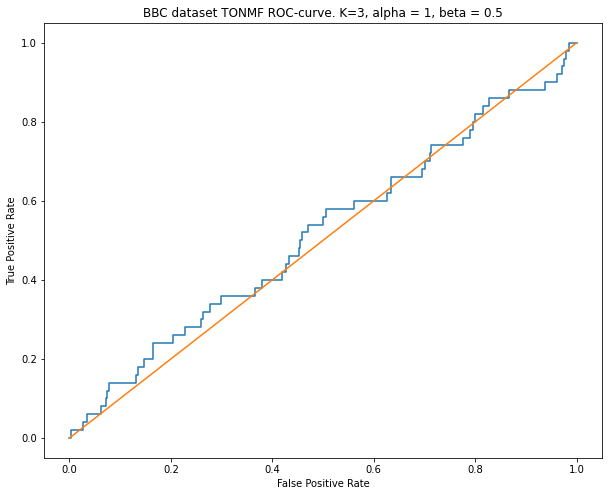

In [81]:
f = plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(list(df_test['y_true'].values), y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
f.savefig("BBC dataset TONMF ROC-curve. K=3, alpha = 1, beta = 0.5.pdf", bbox_inches='tight')
plt.title('BBC dataset TONMF ROC-curve. K=3, alpha = 1, beta = 0.5')

Display ℓ2 norm of columns of $Z$ outlier matrix:

Text(0.5, 1.0, 'Results of TONMF+L2 (outliers - red, non-outliers - blue)')

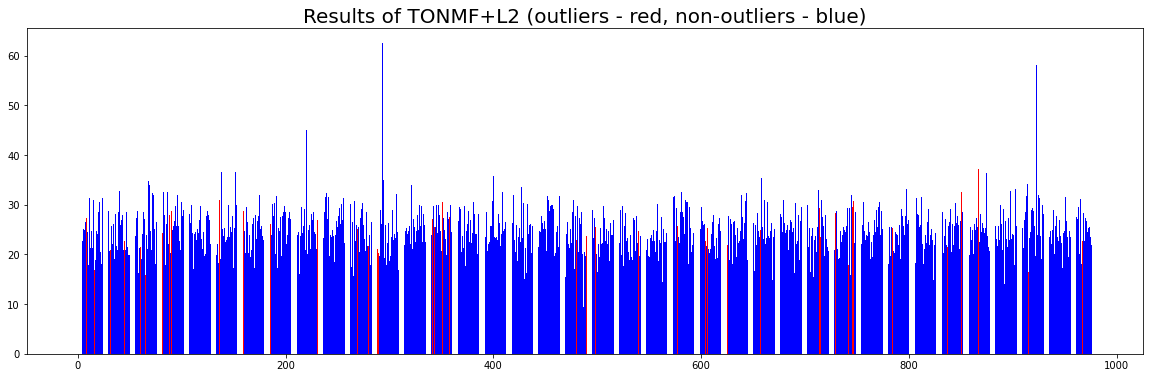

In [82]:
colors_array = np.array(list(df_test['y_true'].values)).astype('str')
colors_array[colors_array == '1'] = 'r'
colors_array[colors_array != 'r'] = 'b'

f = plt.figure(figsize=(20, 6))
index = range(0, len(y_pred))
plt.bar(index, y_pred, color = colors_array)
f.savefig("Results of TONMF+L2 (outliers - red, non-outliers - blue).pdf", bbox_inches='tight')
plt.title("Results of TONMF+L2 (outliers - red, non-outliers - blue)", size = 20)

## RPCA

The function [`rpca_implementation()`](https://alinapetukhova.github.io/textcl/docs/outliers_detection.html#textcl.outliers_detection.rpca_implementation) uses Robust Principal Component Analysis (RPCA) to obtain the outlier matrix. RPCA uses low-rank approximation and yields two matrices: low-rank matrix $L$ and a sparse matrix $S$. After normalization, the $S$ matrix represents the outlier score for the document.

In [83]:
outlier_matrix = textcl.rpca_implementation(bag_of_words)

Normalize with l2-normalization:

Text(0.5, 1.0, 'BBC dataset RPCA ROC-curve')

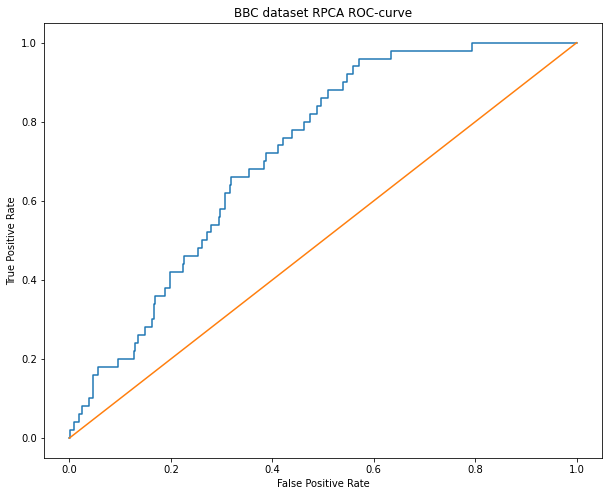

In [84]:
_, y_pred = preprocessing.normalize(outlier_matrix, axis = 1, norm = 'l2', return_norm = True)

f = plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(list(df_test['y_true'].values), y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
f.savefig("BBC dataset RPCA ROC-curve.pdf", bbox_inches='tight')
plt.title('BBC dataset RPCA ROC-curve')

Display ℓ2 norm of columns of Z outlier matrix:

Text(0.5, 1.0, 'Results of RPCA+L2 (outliers - red, non-outliers - blue)')

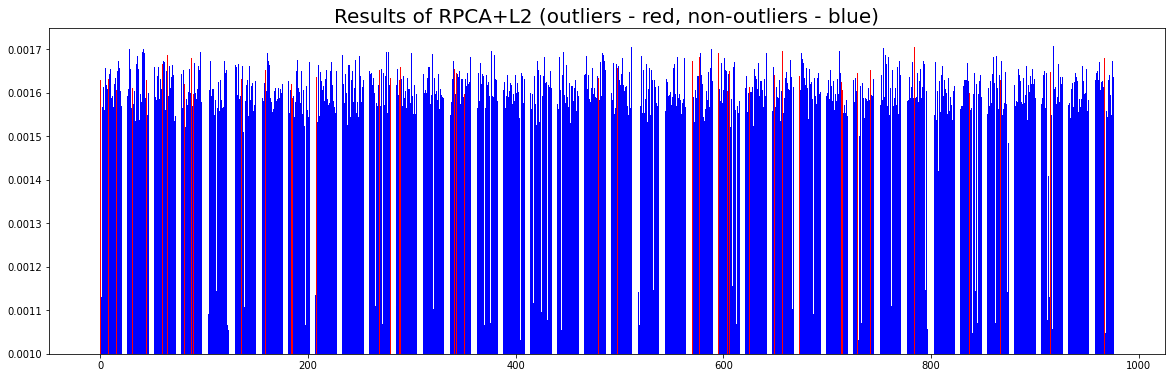

In [85]:
colors_array = np.array(list(df_test['y_true'].values)).astype('str')
colors_array[colors_array == '1'] = 'r'
colors_array[colors_array != 'r'] = 'b'

f = plt.figure(figsize=(20, 6))
plt.ylim(0.001, 0.00175)
index = range(0, len(y_pred))
plt.bar(index, y_pred, color = colors_array)
f.savefig("Results of RPCA+L2 (outliers - red, non-outliers - blue).pdf", bbox_inches='tight')
plt.title("Results of RPCA+L2 (outliers - red, non-outliers - blue)", size = 20)

## SVD

The function [`svd()`](https://alinapetukhova.github.io/textcl/docs/outliers_detection.html#textcl.outliers_detection.svd) uses singular value decomposition (SVD) to obtain the outlier matrix. SVD is performed with the `np.linalg` function from the **numpy** package. The outlier matrix is presented as the multiplication of square root of diagonal elements of the rectangular diagonal matrix $S$ and complex unitary matrix.

In [86]:
outlier_matrix = textcl.svd(bag_of_words)

Normalize with l2-normalization:

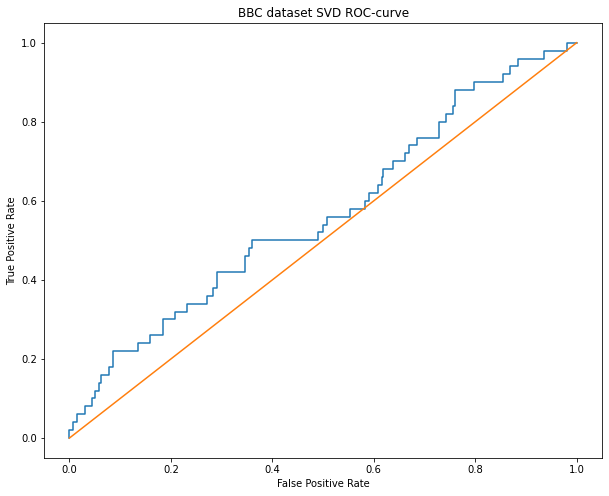

In [87]:
_, y_pred = preprocessing.normalize(outlier_matrix, axis = 1, norm = 'l2', return_norm = True)

f = plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(list(df_test['y_true'].values), y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BBC dataset SVD ROC-curve')
f.savefig("BBC dataset SVD ROC-curve.pdf", bbox_inches='tight')

Display ℓ2 norm of columns of Z outlier matrix:

Text(0.5, 1.0, 'Results of SVD+L2 (outliers - red, non-outliers - blue)')

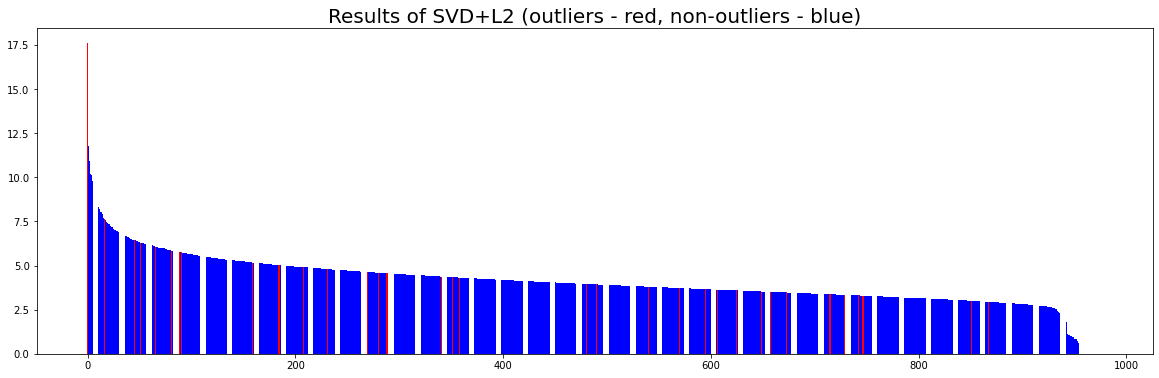

In [88]:
colors_array = np.array(list(df_test['y_true'].values)).astype('str')
colors_array[colors_array == '1'] = 'r'
colors_array[colors_array != 'r'] = 'b'

f = plt.figure(figsize=(20, 6))
# plt.ylim(0.001, 0.00175)
index = range(0, len(y_pred))
plt.bar(index, y_pred, color = colors_array)
f.savefig("Results of SVD+L2 (outliers - red, non-outliers - blue).pdf", bbox_inches='tight')
plt.title("Results of SVD+L2 (outliers - red, non-outliers - blue)", size = 20)

By analyzing obtained plots in these 3 examples we can see that with the current parameters for the BBC data set the **RPCA** method is offering the best results. In the plot "Results of RPCA+L2 (outliers - red, non-outliers - blue)" we can see the abnormal texts have higher values of the ℓ2 norm and can be segmented from the main distribution. The ROC-curve plot was used for the evaluation of the algorithm results and it's clear, what for **RPCA** method it has a higher AUC.